### Project Objective
This notebook aims to build a predictive model to estimate hospital readmission outcomes for diabetes patients. The target variable, readmitted, has three classes: NO, <30 days, and >30 days.

Purpose: 
Accurate predictions of readmission risk can help hospitals allocate resources more efficiently. Patients identified as high risk (especially those likely to return within 30 days) can receive tailored interventions, improved monitoring, or optimized discharge planning. This may reduce unnecessary readmissions and improve bed and staff utilization.

### Note: Why the <30 Days Readmission Class Matters

Readmissions within 30 days are widely used in healthcare as a key quality indicator. They often signal unresolved medical issues, inadequate discharge planning, or complications that arise shortly after the patient leaves the hospital. Hospitals typically monitor this category closely because these readmissions are considered more preventable and are sometimes tied to financial or performance evaluations.
For this reason, achieving strong model performance on the <30 class is particularly valuable for clinical decision-making and resource planning.

### Dataset Information

Source

The dataset is sourced from Kaggle. A preprocessed version of the data is used in this notebook; missing values have been handled, relevant feature engineering has been performed, and unnecessary columns have been removed. We will load the dataset from the file cleaned_df.pkl.

What Each Row Represents

Each row corresponds to an individual patient encounter, containing demographic details, medical history, and hospital-related information such as medications, procedures, and diagnostic attributes.

Major Feature Categories:

1) Demographics (age, gender, race, etc.)

2) Medication-related variables

3) Lab tests and procedures

4) Encounter and admission details

Problem Type
This is a multiclass classification task in which the goal is to predict patient readmission outcomes into three categories: NO, <30 days, and >30 days.

# 1) Initial Data Checks
i) load the pickle file from ../Data/Processed/cleaned_df.pkl

ii) print head to check the contents and if the pickle file is loaded correctly

iii) review the structure and column types to get an idea about the dataframe and if it needs any further processing

iv) check the summary statistics to look for any unusal trends or patterns in the data

v) Check the distribution of the class variable to see if it balanced or unbalanced so that it could be handled accordingly during modelling step

# 2) Modelling Approach

i) Models to Try and Rationale

Begin with a simple baseline model such as Logistic Regression to establish reference performance using accuracy, precision, recall, and F1-score. If performance is limited, explore more complex algorithms including Support Vector Machines (SVM), Decision Trees, Random Forests, Bagging and Boosting methods, and Artificial Neural Networks (ANN). Each model will be tuned through appropriate hyperparameters to improve predictive performance.

ii) Data Splitting Strategy

Because this is a binary class classification problem, the dataset will be split into training and testing sets using a stratified train–test split to ensure the class proportions are preserved across both sets.

iii) Evaluation Metrics

Model performance will be evaluated using precision, recall, F1-score, and confusion matrices to understand class-wise behavior and overall predictive capability.

iv) Model Comparison Approach

Models will be compared using their confusion matrices and aggregate performance metrics. Special attention will be given to maintaining a strong balance between recall and F1-score, especially for the clinically important <30 days readmission class.

v) Constraints and Considerations

Potential class imbalance may affect model performance, particularly for minority classes. If needed, techniques such as class weighting or resampling will be considered during model development

# 3) Modelling Data Preparation

1. Feature Selection

All feature cleaning, removal of highly correlated variables, and elimination of irrelevant columns were completed during preprocessing. In this notebook, all remaining columns will be used as features, with readmitted serving as the target variable.

2. Handling Categorical and Numerical Variables

Numerical features: Standardized using StandardScaler.
Categorical features:
Low-cardinality categories: Encoded using One-Hot Encoding (OHE).
High-cardinality categories: Encoded using Target Encoding to reduce dimensionality and maintain signal strength.

3. Preprocessing Structure (Pipeline and ColumnTransformer)
A ColumnTransformer will be used to apply different transformations to numerical and categorical features.
A Pipeline will incorporate preprocessing and the selected model, ensuring consistent and reproducible transformations during training and evaluation.

4. Handling Class Imbalance
If class imbalance is observed, techniques such as SMOTE or alternative balancing strategies may be applied to improve minority-class performance.

5. Reproducibility
A fixed random_state will be used throughout the workflow, and the train–test split will be stratified to maintain class proportions in both sets.

# 4) Baseline Model plan (logistic Regression)

1. Purpose of the Baseline Model

i) Establish an initial performance benchmark for all subsequent models.

ii) Assess the overall difficulty of the prediction task.

iii) Gain early insights into data behavior and model fit, helping determine whether additional EDA or feature engineering may be needed.

2. Evaluation Metrics
The baseline model will be evaluated using:

i) Precision

ii) Recall

iii) F1-score

iv) Confusion matrix
These metrics will provide class-level insights, particularly for the clinically important <30 days readmission class.

3. Decisions Guided by the Baseline Results

i) Whether more complex models are required to improve performance.

ii) Whether class imbalance needs additional treatment (e.g., SMOTE, class weights).

iii) Whether the preprocessing pipeline (scaling, encoding) is functioning as expected.

# 5) Model Training Workflow Plan

i) Load the data

ii) Separate the target and feature columns

iii) Split into training and testing set

iv) Apply the column transformations

v) Train the baseline logistic regression

vi) Evaluate the base line model

vii) Iterate and tune the parameters

viii) Iterate with more models

ix) Compare performance across models

x) Choose final model

In [51]:
import pickle
with open('../Data/Processed/cleaned_df.pkl', 'rb') as f:
    cleaned_df=pickle.load(f)
print(cleaned_df.shape)
print(cleaned_df.head())
print(cleaned_df.info())
print(cleaned_df.describe())
print(cleaned_df['readmitted'].value_counts())

(101766, 50)
       patient_nbr  ...                                    diag_3_category
4267           135  ...                   Diseases Of The Digestive System
4780           135  ...  Endocrine, Nutritional And Metabolic Diseases,...
5827           378  ...  Endocrine, Nutritional And Metabolic Diseases,...
67608          729  ...  Supplementary Classification Of External Cause...
17494          774  ...                 Diseases Of The Circulatory System

[5 rows x 50 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 4267 to 96147
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   patient_nbr                          101766 non-null  int64  
 1   race                                 101766 non-null  object 
 2   gender                               101766 non-null  object 
 3   age                                  101766 non-null  object 
 4  

# Data Splitting into training and test set

## Patient ID Splitting is Required
Standard train_test_split operates randomly on rows, ignoring patient identity. Because we created powerful, sequential features based on patient history (patient_historical_readmission_rate), a random split will mix a patient's early encounters (past) into the Test Set and their later encounters (future) into the Training Set.

This causes a catastrophic form of data leakage, artificially inflating performance metrics (like precision and F1-score) because the model is tested on data it has implicitly seen (i.e., the future outcome of the same patient).

Solution: We must split the data at the Patient ID level, ensuring all encounters for a single patient reside entirely in either the Training Set or the Test Set.

Implementation: Patient-Level Train/Test Split
This process ensures that the Test Set contains truly "unseen" patients, providing an honest evaluation of the model's ability to generalize.

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
# -----------------------------------------------------------
# 1. Define Features (X) and Target (Y)
# -----------------------------------------------------------

# Columns that must be excluded from the Feature set (X)
COLUMNS_TO_EXCLUDE = [
    'readmitted',           # The original multi-class target
    'readmitted_30d',       # The binary target we will use (Y_binary)
    'cum_readmissions',     # Intermediate calculation column
    #'weight',             # Uncomment this line if you decide to drop 'weight' due to missingness
]

# Define the full feature set X, keeping 'patient_nbr' temporarily for the split
X_full = cleaned_df.drop(columns=COLUMNS_TO_EXCLUDE, errors='ignore')

# Define the binary target Y (1 for <30 days, 0 otherwise)
Y_binary = (cleaned_df['readmitted'] == '<30').astype(int)

# -----------------------------------------------------------
# 2. Patient-Level Split Logic (CRITICAL)
# -----------------------------------------------------------

# A. Identify the unique patient IDs
unique_patients = X_full['patient_nbr'].unique()

# B. Split the PATIENT IDs (NOT the rows)
# We use a random state for reproducibility
patient_train_ids, patient_test_ids = train_test_split(
    unique_patients, 
    test_size=0.2, 
    random_state=42 
)

# C. Filter the entire dataset based on the patient IDs
# --- Training Set ---
# X_train rows are those belonging to the training patient IDs
X_train = X_full[X_full['patient_nbr'].isin(patient_train_ids)].copy()
# y_train must align perfectly with X_train indices
y_train = Y_binary.loc[X_train.index].copy()

# --- Test Set ---
# X_test rows are those belonging to the test patient IDs
X_test = X_full[X_full['patient_nbr'].isin(patient_test_ids)].copy()
# y_test must align perfectly with X_test indices
y_test = Y_binary.loc[X_test.index].copy()

# -----------------------------------------------------------
# 3. Final Feature Cleanup: Drop Identifiers from X
# -----------------------------------------------------------
# The 'patient_nbr' column is only used for the split, NOT for model training!
X_train.drop('patient_nbr', axis=1, inplace=True)
X_test.drop('patient_nbr', axis=1, inplace=True)

# -----------------------------------------------------------
# 4. Verification and Output
# -----------------------------------------------------------
print("--- Data Split Summary ---")
print(f"Total encounters: {len(X_full)}")
print(f"Training encounters: {len(X_train)} (Unique Patients: {len(patient_train_ids)})")
print(f"Testing encounters: {len(X_test)} (Unique Patients: {len(patient_test_ids)})")
print("-" * 25)
print(f"X_train feature count: {X_train.shape[1]}")
print(f"X_train feature list: {list(X_train.columns)}")

--- Data Split Summary ---
Total encounters: 101766
Training encounters: 81613 (Unique Patients: 57214)
Testing encounters: 20153 (Unique Patients: 14304)
-------------------------
X_train feature count: 46
X_train feature list: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'patient_prior_encounters', 'patient_historical_readmission_rate', '

In [53]:
print(len(patient_train_ids) == len(set(patient_train_ids)))
print(len(patient_test_ids) == len(set(patient_test_ids)))

True
True


# Data Preprocessing

In [54]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix

# 1. Redefine Column Lists for Simplified Preprocessing
# Get all numerical columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
# Combine ALL categorical columns for safe OHE in the LogReg baseline
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# 2. Define Preprocessor for Logistic Regression 
preprocess = ColumnTransformer(transformers=[
    ("numeric_cols", StandardScaler(), numeric_cols),
    
    ("categorical_cols", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), categorical_cols)
])


In [55]:
from sklearn import set_config
set_config(display="diagram")

# Logistic Regression

In [56]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from typing import Union, Dict, Any, Tuple # Keeping type hints here is good practice

# Scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.compose import ColumnTransformer

def plot_coefficients(pipe: Pipeline, n_top_features: int = 10):
    """Extracts and plots the top N absolute coefficients, returning the Figure object."""
    
    logreg_model = pipe['logistic_regression']
    feature_names = pipe['preprocess'].get_feature_names_out()
    coefficients = logreg_model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute_Coefficient': np.abs(coefficients)
    })
    # Sort and select top N features by absolute value
    plot_data = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).head(n_top_features)
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=plot_data)
    plt.title(f'Top {n_top_features} Logistic Regression Feature Coefficients')
    plt.xlabel('Coefficient Value (Positive = Class 1 Likelihood)')
    plt.grid(axis='x', linestyle='--')    
    return fig

def plot_roc_curve(pipe: Pipeline, X_test, y_test):
    """Calculates and plots the ROC curve, returning the Figure object."""
    # Get probability predictions for the positive class (Class 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")    
    return fig
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_metrics(pipe: Pipeline, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.05, 1.01, 0.05)
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        rows.append({
            "Threshold": round(t, 2),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Positive Rate": y_pred.mean()   # % of population flagged diabetic
        })

    return pd.DataFrame(rows)

def run_logistic_regression(preprocess, X_train, y_train, X_test, y_test, logreg_params=None, output_dir="../Outputs/Logistic_Regression"):
    
    default_logreg_params = {"C": 1.0, "penalty": "l2", "solver": "lbfgs"}
    if logreg_params is None:
        logreg_params = default_logreg_params

    log_reg = LogisticRegression(max_iter=300, class_weight="balanced", random_state=42, **logreg_params)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("logistic_regression", log_reg)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print("\n--- Evaluation Summary (Logistic Regression) ---")
    print(f"Parameters Used: {logreg_params}")
    
    print("\n--- Detailed Evaluation Metrics ---")
    pprint.pprint(metrics)
    
    # Create Directory
    try:
        os.makedirs(output_dir, exist_ok=True)
        print(f"\nResults will be saved in: {os.path.abspath(output_dir)}")
    except OSError as e:
        print(f"Error creating directory: {e}")

    # Generate and Save Plots
    print("\n--- Generating Model Insights Plots... ---")
    
    # Generate and save Coefficient Plot
    coef_fig = plot_coefficients(pipe)
    coef_fig.savefig(os.path.join(output_dir, "feature_coefficients.png"), bbox_inches='tight')
    plt.show()
    plt.close(coef_fig) 
    
    # Generate and save ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()
    plt.close(roc_fig) 
    
    # Save the Metrics (SIMPLE TXT FILE)
    metrics_filename = os.path.join(output_dir, "metrics.txt")
    try:
        metrics_string = pprint.pformat(metrics)
        
        with open(metrics_filename, 'w') as f:
            f.write("--- Logistic Regression Evaluation Metrics ---\n\n")
            f.write(metrics_string)
            
        print("Metrics (TXT) saved successfully.")
    except Exception as e:
        print(f"Error saving metrics to TXT file: {e}")
    
    # -------- Threshold-level performance --------
    print("\n--- Threshold Analysis ---")
    threshold_df = threshold_metrics(pipe, X_test, y_test)
    print(threshold_df)

    # Save threshold table
    threshold_path = os.path.join(output_dir, "threshold_metrics.csv")
    threshold_df.to_csv(threshold_path, index=False)
    print(f"Threshold metrics saved to: {threshold_path}")

    return pipe, metrics

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_25168/1313213588.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coef', y='Feature', data=plot_data, palette='coolwarm')



--- Evaluation Summary (Logistic Regression) ---
Parameters Used: {'C': 0.05, 'solver': 'saga'}

--- Detailed Evaluation Metrics ---
{'accuracy': 0.6628293554309532,
 'classification_report': {'0': {'f1-score': 0.7826782230466626,
                                 'precision': 0.9224274406332453,
                                 'recall': 0.6797022553049661,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.24825755061400598,
                                 'precision': 0.16289198606271776,
                                 'recall': 0.5216178521617852,
                                 'support': 2151.0},
                           'accuracy': 0.6628293554309532,
                           'macro avg': {'f1-score': 0.5154678868303343,
                                         'precision': 0.5426597133479816,
                                         'recall': 0.6006600537333757,
                                         'support': 20153.0

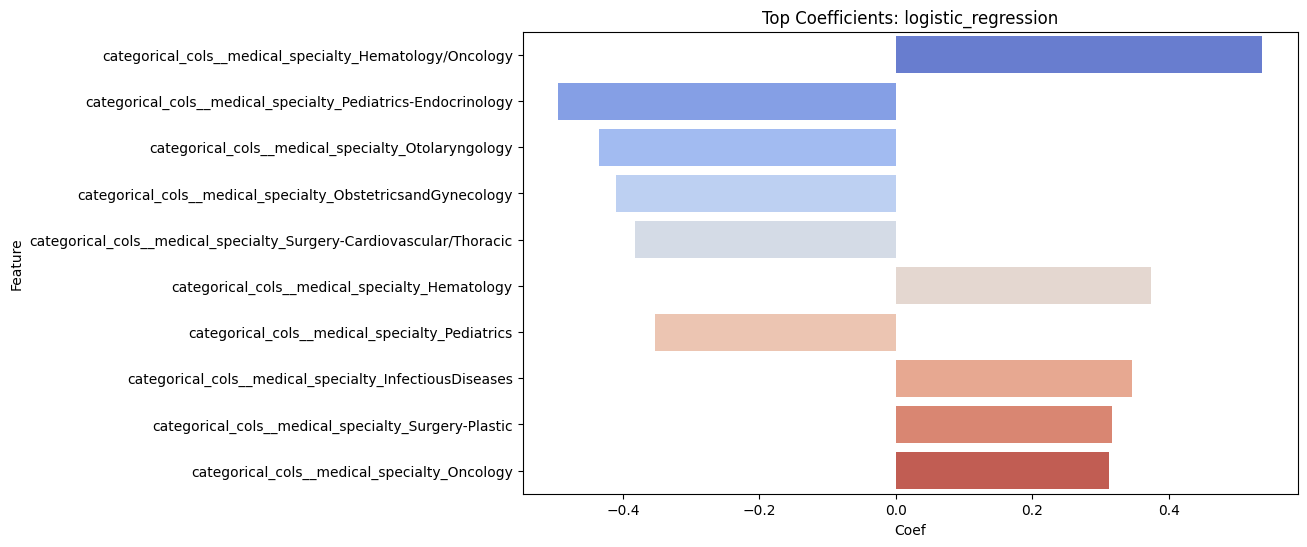

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


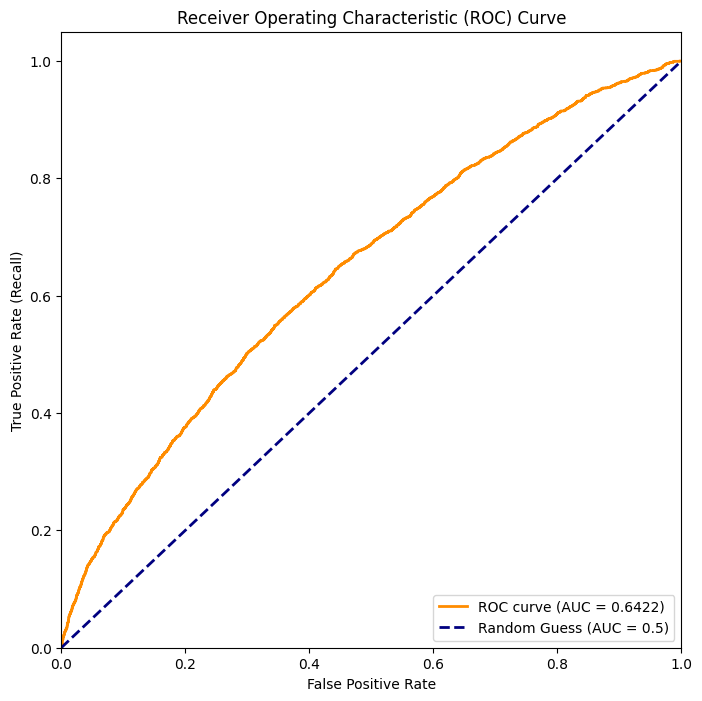

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


Metrics (TXT) saved successfully.

--- Threshold Analysis ---
    Threshold  Precision    Recall        F1  Positive Rate
0        0.05   0.106733  1.000000  0.192880       1.000000
1        0.10   0.106733  1.000000  0.192880       1.000000
2        0.15   0.106744  1.000000  0.192897       0.999901
3        0.20   0.107036  1.000000  0.193374       0.997172
4        0.25   0.107964  0.997675  0.194843       0.986305
5        0.30   0.110190  0.982334  0.198153       0.951521
6        0.35   0.116837  0.942352  0.207897       0.860864
7        0.40   0.126476  0.836820  0.219740       0.706198
8        0.45   0.141919  0.683403  0.235031       0.513968
9        0.50   0.162892  0.521618  0.248258       0.341785
10       0.55   0.184936  0.370990  0.246830       0.214112
11       0.60   0.210251  0.261274  0.233002       0.132635
12       0.65   0.248768  0.187820  0.214040       0.080584
13       0.70   0.285403  0.121804  0.170740       0.045552
14       0.75   0.307985  0.075314  0.

,steps,"[('preprocess', ...), ('logistic_regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric_cols', ...), ('categorical_cols', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a str

In [83]:
pipe_lr, metrics_lr = run_logistic_regression(preprocess,X_train,y_train,X_test,y_test,logreg_params={'C':0.05,'solver': 'saga'})
pipe_lr

## Interpretaion of the results of logistic regression model
Feature importance plot: 
The Y-axis shows the top 10 most impactful features that are influencing the class 1 (<30). The X-axis shows the coef values which determine the direction of the influence; the sign + or - are infuencing the prediction of class 1 in that manner. In summary: The model is likely trying to predict which patients will be readmitted within a month of discharge, and it has correctly identified that patients with Oncology issues are high-risk (Class 1) and patients with Obstetrics/Childbirth issues are low-risk (Class 0).

ROC Curve: The curve illustrates the trade-off between the ability to correctly identify positive instances (high TPR) and the ability to avoid misclassifying negative instances (low FPR). 

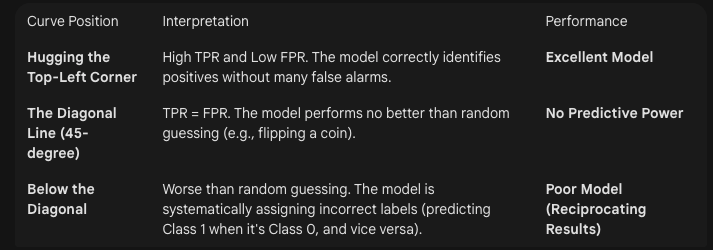

The single most important metric derived from the ROC curve is the Area Under the ROC Curve (AUC). The AUC is a single scalar value (ranging from 0.5 to 1.0) that summarizes the model's overall ability to discriminate between the positive and negative classes across all possible thresholds.

Interpretation as a Probability: A common interpretation is that the AUC represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

AUC = 1.0: Perfect classification.

AUC = 0.9: Excellent discrimination (90% chance of correctly ranking a positive higher than a negative).

AUC = 0.5: Random guessing.

The ROC-AUC of 0.64 indicates the model has learned some signal but its discriminative power is still limited. In particular, at low false-positive rates the recall is poor, which is problematic for a screening task. This suggests we need to improve feature representation and model capacity before optimizing decision thresholds.

# For imbalanced dataset apply SMOTE

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from typing import Union, Dict, Any, Tuple # Keeping type hints here is good practice

# Scikit-learn imports
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

def plot_coefficients(pipe: Pipeline, n_top_features: int = 10):
    """Extracts and plots the top N absolute coefficients, returning the Figure object."""
    
    logreg_model = pipe['model']
    feature_names = pipe['preprocess'].get_feature_names_out()
    coefficients = logreg_model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute_Coefficient': np.abs(coefficients)
    })
    # Sort and select top N features by absolute value
    plot_data = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).head(n_top_features)
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=plot_data)
    plt.title(f'Top {n_top_features} Logistic Regression Feature Coefficients')
    plt.xlabel('Coefficient Value (Positive = Class 1 Likelihood)')
    plt.grid(axis='x', linestyle='--')    
    return fig

def plot_roc_curve(pipe: Pipeline, X_test, y_test):
    """Calculates and plots the ROC curve, returning the Figure object."""
    # Get probability predictions for the positive class (Class 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")    
    return fig
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_metrics(pipe: Pipeline, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.05, 1.01, 0.05)
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        rows.append({
            "Threshold": round(t, 2),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Positive Rate": y_pred.mean()   # % of population flagged diabetic
        })

    return pd.DataFrame(rows)

def run_logistic_regression_smote(preprocess, X_train, y_train, X_test, y_test, logreg_params=None, output_dir="../Outputs/Logistic_Regression_smote"):
    
    default_logreg_params = {"C": 1.0, "penalty": "l2", "solver": "lbfgs"}
    if logreg_params is None:
        logreg_params = default_logreg_params

    log_reg = LogisticRegression(max_iter=300, class_weight="balanced", random_state=42, **logreg_params)
    pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=300, random_state=42))])
    #pipe = Pipeline(steps=[("preprocess", preprocess), ("logistic_regression", log_reg)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print("\n--- Evaluation Summary (Logistic Regression) ---")
    print(f"Parameters Used: {logreg_params}")
    
    print("\n--- Detailed Evaluation Metrics ---")
    pprint.pprint(metrics)
    
    # Create Directory
    try:
        os.makedirs(output_dir, exist_ok=True)
        print(f"\nResults will be saved in: {os.path.abspath(output_dir)}")
    except OSError as e:
        print(f"Error creating directory: {e}")

    # Generate and Save Plots
    print("\n--- Generating Model Insights Plots... ---")
    
    # Generate and save Coefficient Plot
    coef_fig = plot_coefficients(pipe)
    coef_fig.savefig(os.path.join(output_dir, "feature_coefficients.png"), bbox_inches='tight')
    plt.show()
    plt.close(coef_fig) 
    
    # Generate and save ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()
    plt.close(roc_fig) 
    
    # Save the Metrics (SIMPLE TXT FILE)
    metrics_filename = os.path.join(output_dir, "metrics.txt")
    try:
        metrics_string = pprint.pformat(metrics)
        
        with open(metrics_filename, 'w') as f:
            f.write("--- Logistic Regression Evaluation Metrics ---\n\n")
            f.write(metrics_string)
            
        print("Metrics (TXT) saved successfully.")
    except Exception as e:
        print(f"Error saving metrics to TXT file: {e}")
    
    # -------- Threshold-level performance --------
    print("\n--- Threshold Analysis ---")
    threshold_df = threshold_metrics(pipe, X_test, y_test)
    print(threshold_df)

    # Save threshold table
    threshold_path = os.path.join(output_dir, "threshold_metrics.csv")
    threshold_df.to_csv(threshold_path, index=False)
    print(f"Threshold metrics saved to: {threshold_path}")

    return pipe, metrics


--- Evaluation Summary (Logistic Regression) ---
Parameters Used: {'C': 0.05, 'solver': 'saga'}

--- Detailed Evaluation Metrics ---
{'accuracy': 0.6313203989480475,
 'classification_report': {'0': {'f1-score': 0.7572847249444662,
                                 'precision': 0.9191911181601903,
                                 'recall': 0.6438729030107766,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.2335465236228595,
                                 'precision': 0.15007291528569536,
                                 'recall': 0.5262668526266853,
                                 'support': 2151.0},
                           'accuracy': 0.6313203989480475,
                           'macro avg': {'f1-score': 0.4954156242836628,
                                         'precision': 0.5346320167229428,
                                         'recall': 0.5850698778187309,
                                         'support': 20153.0}

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_25168/1313213588.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coef', y='Feature', data=plot_data, palette='coolwarm')


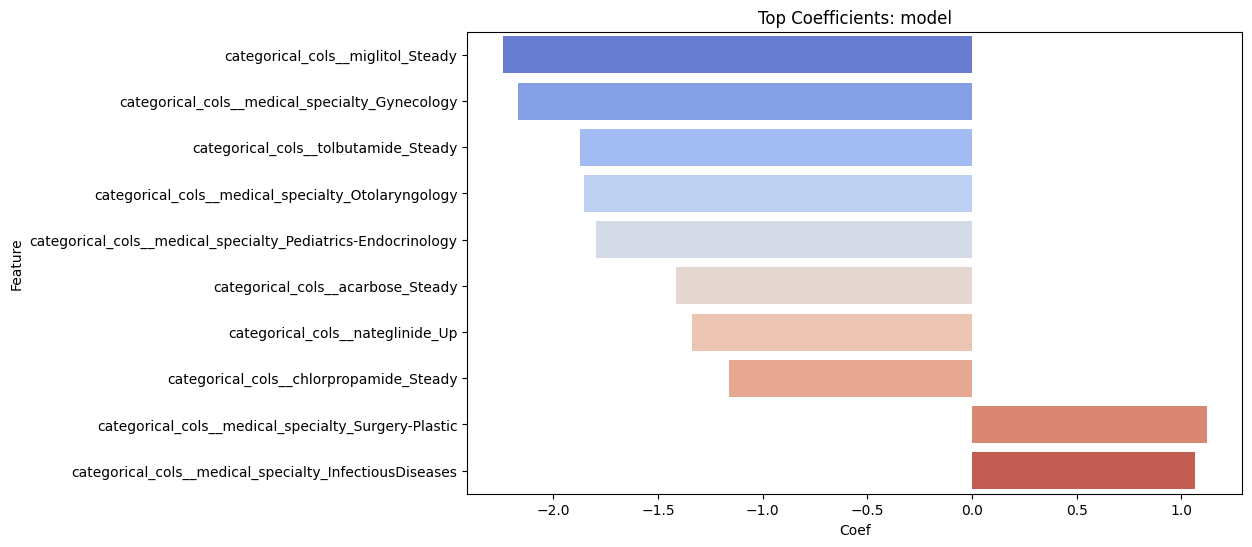

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


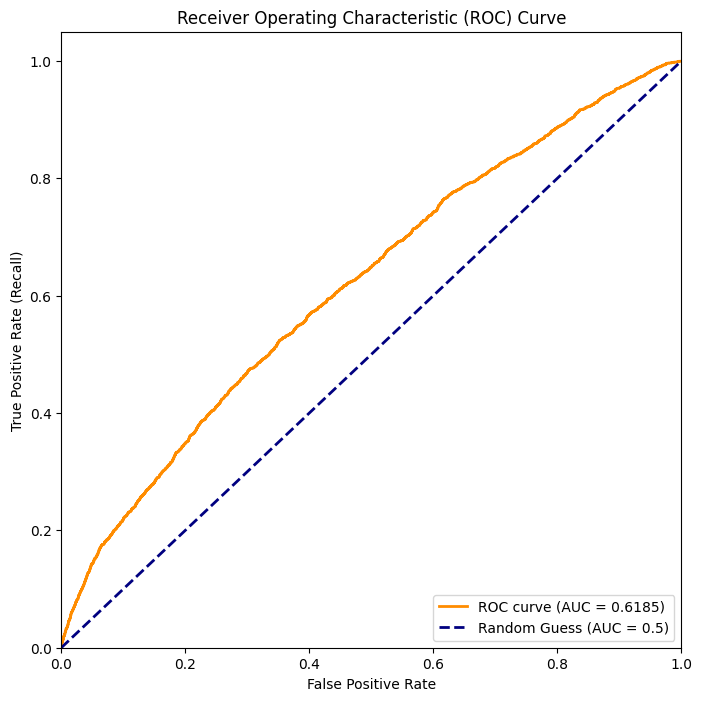

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


Metrics (TXT) saved successfully.

--- Threshold Analysis ---
    Threshold  Precision    Recall        F1  Positive Rate
0        0.05   0.106976  0.999535  0.193267       0.997271
1        0.10   0.107143  0.998605  0.193522       0.994790
2        0.15   0.107715  0.997675  0.194437       0.988587
3        0.20   0.108942  0.991167  0.196308       0.971071
4        0.25   0.110840  0.970711  0.198961       0.934749
5        0.30   0.114053  0.929335  0.203171       0.869697
6        0.35   0.118620  0.856811  0.208390       0.770952
7        0.40   0.127790  0.777313  0.219495       0.649233
8        0.45   0.134664  0.642957  0.222687       0.509602
9        0.50   0.150073  0.526267  0.233547       0.374287
10       0.55   0.166634  0.398884  0.235068       0.255495
11       0.60   0.183222  0.281265  0.221896       0.163847
12       0.65   0.216474  0.200372  0.208112       0.098794
13       0.70   0.258176  0.139470  0.181105       0.057659
14       0.75   0.277049  0.078568  0.

,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric_cols', ...), ('categorical_cols', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready

In [84]:
pipe, metrics = run_logistic_regression_smote(preprocess,X_train,y_train,X_test,y_test,logreg_params={'C':0.05,'solver': 'saga'})
pipe

# Decision Tree Classifier

In [60]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from typing import Union, Dict, Any, Tuple # Keeping type hints here is good practice

# Scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.compose import ColumnTransformer

def plot_feature_importances(pipe: Pipeline, n_top_features: int = 10):
    """
    Extracts and plots feature importances for a Decision Tree.
    Note: Decision Trees use 'feature_importances_', not 'coef_'.
    """
    dt_model = pipe['Decision_tree']
    feature_names = pipe['preprocess'].get_feature_names_out()
    
    # Decision Trees use Feature Importance (all values are positive and sum to 1)
    importances = dt_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort and select top N
    plot_data = importance_df.sort_values(by='Importance', ascending=False).head(n_top_features)
    
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')
    plt.title(f'Top {n_top_features} Decision Tree Feature Importances')
    plt.xlabel('Importance Score (Higher = More Predictive)')
    plt.grid(axis='x', linestyle='--')    
    return fig
def plot_roc_curve(pipe: Pipeline, X_test, y_test):
    """Calculates and plots the ROC curve, returning the Figure object."""
    # Get probability predictions for the positive class (Class 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")    
    return fig
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_metrics(pipe: Pipeline, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.05, 1.01, 0.05)
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        rows.append({
            "Threshold": round(t, 2),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Positive Rate": y_pred.mean()   # % of population flagged diabetic
        })

    return pd.DataFrame(rows)

def run_decision_tree(preprocess, X_train, y_train, X_test, y_test, dt_params=None, output_dir="../Outputs/Decision_tree"):
    
    # Default parameters for a Decision Tree
    default_dt_params = {"max_depth": 5, "class_weight":"balanced" , "min_samples_leaf": 100, "random_state": 42}
    if dt_params is None:
        dt_params = default_dt_params

    # Initialize model and pipeline
    dt_model = DecisionTreeClassifier(**dt_params)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("Decision_tree", dt_model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }

    print("\n--- Evaluation Summary (Decision Tree) ---")
    print(f"Parameters Used: {dt_params}") # Fixed from logreg_params
    pprint.pprint(metrics)
    
    os.makedirs(output_dir, exist_ok=True)

    # 1. Feature Importance Plot (Updated from Coefficients)
    imp_fig = plot_feature_importances(pipe)
    imp_fig.savefig(os.path.join(output_dir, "feature_importance.png"), bbox_inches='tight')
    plt.show()
    
    # 2. Tree Visualization (New: Very helpful for Decision Trees)
    plt.figure(figsize=(20,10))
    plot_tree(pipe['Decision_tree'], 
              feature_names=pipe['preprocess'].get_feature_names_out(), 
              filled=True, max_depth=3, fontsize=10)
    plt.title("Decision Tree Structure (First 3 Levels)")
    plt.savefig(os.path.join(output_dir, "tree_structure.png"))
    plt.show()

    # 3. ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()

    # Save Metrics
    metrics_filename = os.path.join(output_dir, "metrics.txt")
    with open(metrics_filename, 'w') as f:
        f.write("--- Decision Tree Evaluation Metrics ---\n\n")
        f.write(pprint.pformat(metrics))
    
    # Threshold Analysis
    threshold_df = threshold_metrics(pipe, X_test, y_test)
    threshold_df.to_csv(os.path.join(output_dir, "threshold_metrics.csv"), index=False)

    return pipe, metrics


--- Evaluation Summary (Decision Tree) ---
Parameters Used: {'max_depth': 5, 'class_weight': 'balanced', 'min_samples_leaf': 100, 'random_state': 42}
{'accuracy': 0.6076514662829355,
 'classification_report': {'0': {'f1-score': 0.7338516947726278,
                                 'precision': 0.9311523020415137,
                                 'recall': 0.6055438284635041,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.253845427951307,
                                 'precision': 0.15924698081932276,
                                 'recall': 0.6252905625290562,
                                 'support': 2151.0},
                           'accuracy': 0.6076514662829355,
                           'macro avg': {'f1-score': 0.4938485613619674,
                                         'precision': 0.5451996414304182,
                                         'recall': 0.6154171954962802,
                                         'su

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_25168/1313213588.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')


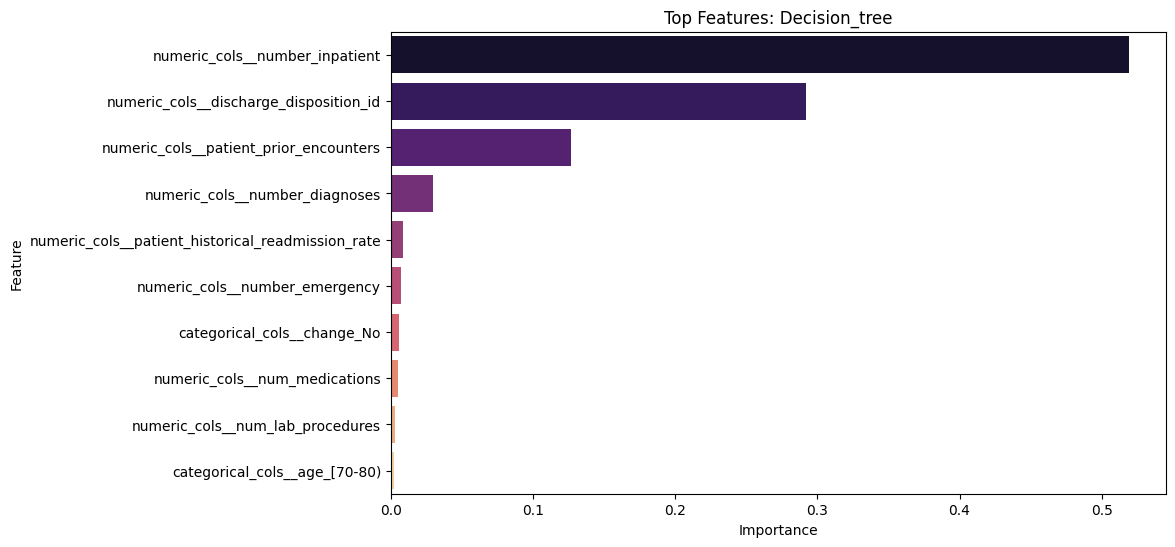

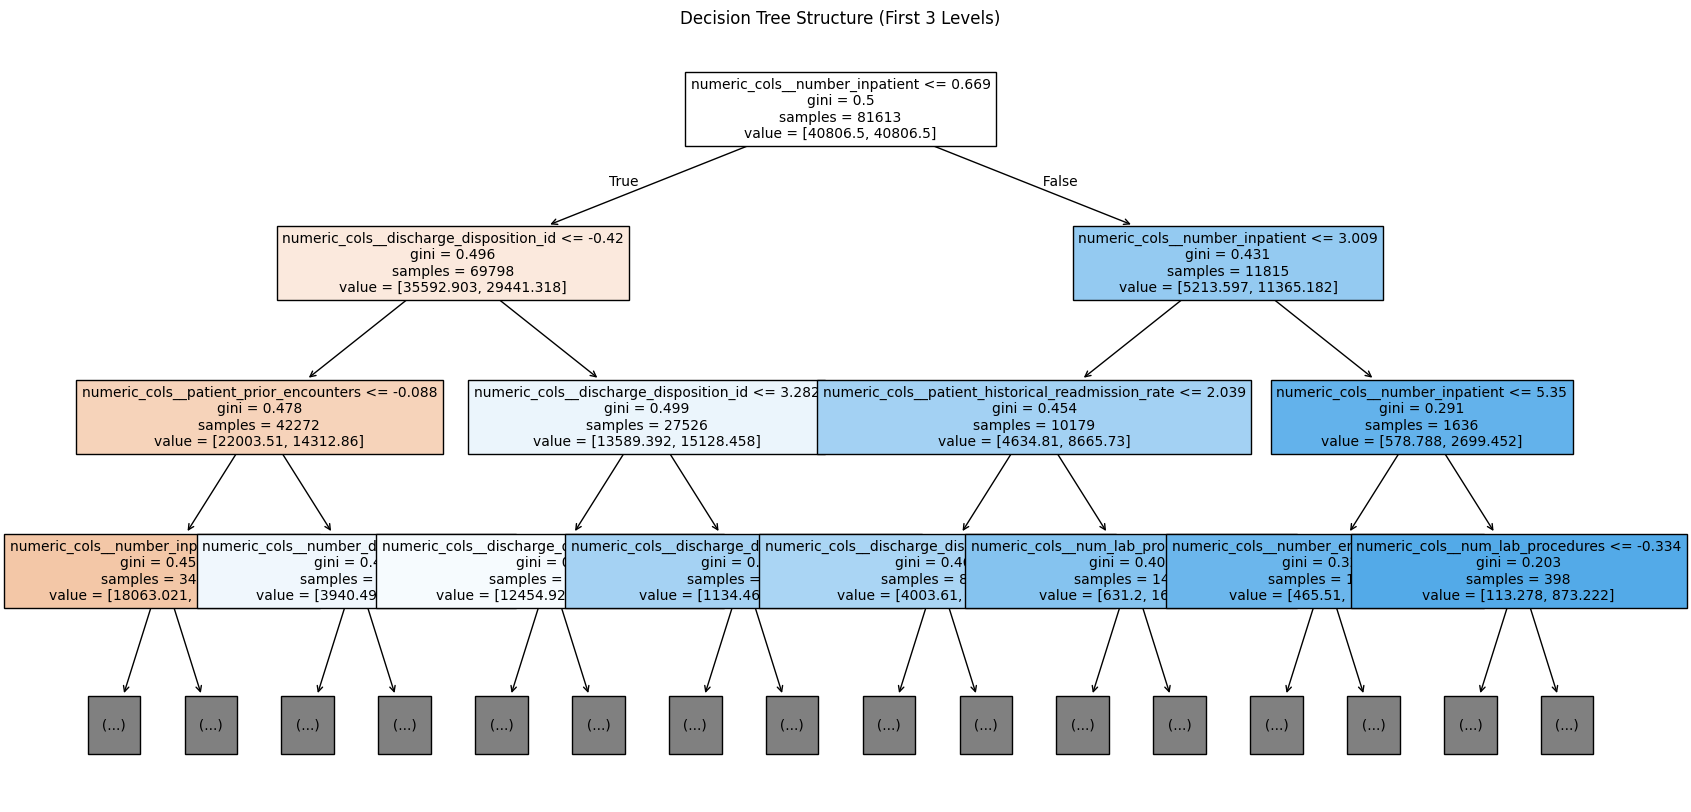

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


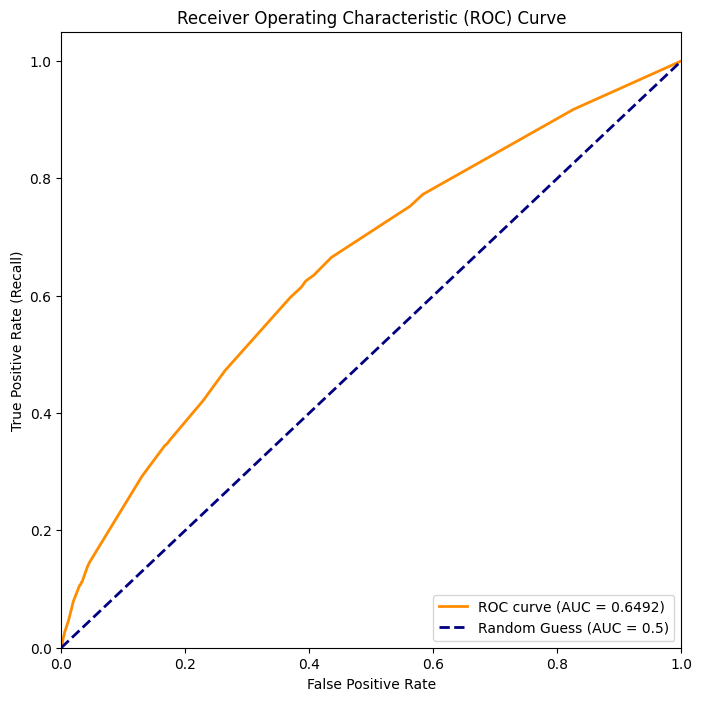

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


,steps,"[('preprocess', ...), ('Decision_tree', ...)]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric_cols', ...), ('categorical_cols', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string re

In [85]:
pipe_dt, metrics_dt = run_decision_tree(preprocess,X_train,y_train,X_test,y_test)
pipe_dt

# Random Forest Classifier

In [64]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from typing import Union, Dict, Any, Tuple # Keeping type hints here is good practice

# Scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.compose import ColumnTransformer

def plot_feature_importances(pipe: Pipeline, n_top_features: int = 10):
    """
    Extracts and plots feature importances for a Random Forest .
    Note: Random Forest  use 'feature_importances_', not 'coef_'.
    """
    rf_model = pipe['Random_forest']
    feature_names = pipe['preprocess'].get_feature_names_out()
    
    # Random Forest use Feature Importance (all values are positive and sum to 1)
    importances = rf_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort and select top N
    plot_data = importance_df.sort_values(by='Importance', ascending=False).head(n_top_features)
    
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')
    plt.title(f'Top {n_top_features} Random Forest Feature Importances')
    plt.xlabel('Importance Score (Higher = More Predictive)')
    plt.grid(axis='x', linestyle='--')    
    return fig
def plot_roc_curve(pipe: Pipeline, X_test, y_test):
    """Calculates and plots the ROC curve, returning the Figure object."""
    # Get probability predictions for the positive class (Class 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")    
    return fig
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_metrics(pipe: Pipeline, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.05, 1.01, 0.05)
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        rows.append({
            "Threshold": round(t, 2),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Positive Rate": y_pred.mean()   # % of population flagged diabetic
        })

    return pd.DataFrame(rows)

def run_random_forest(preprocess, X_train, y_train, X_test, y_test, rf_params=None, output_dir="../Outputs/Random_forest"):
    
    # Default parameters for a Random Forest
    default_rf_params = {"random_state": 42, "class_weight":'balanced', "n_estimators":500,"max_depth":8,"min_samples_leaf":50}
    if rf_params is None:
        rf_params = default_rf_params

    # Initialize model and pipeline
    rf_model = RandomForestClassifier(**rf_params)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("Random_forest", rf_model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }

    print("\n--- Evaluation Summary (Random forest) ---")
    print(f"Parameters Used: {rf_params}") # Fixed from logreg_params
    pprint.pprint(metrics)
    
    os.makedirs(output_dir, exist_ok=True)

    # 1. Feature Importance Plot (Updated from Coefficients)
    imp_fig = plot_feature_importances(pipe)
    imp_fig.savefig(os.path.join(output_dir, "feature_importance.png"), bbox_inches='tight')
    plt.show()
    
    # 2. Tree Visualization (New: Very helpful for Random forest)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    for index in range(0, 3):
        plot_tree(rf_model.estimators_[index],
                feature_names=pipe['preprocess'].get_feature_names_out(),
                filled=True,
                ax=axes[index],
                max_depth=2)
        axes[index].set_title(f'Tree {index}')

    plt.tight_layout()
    plt.show()

    # 3. ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()

    # Save Metrics
    metrics_filename = os.path.join(output_dir, "metrics.txt")
    with open(metrics_filename, 'w') as f:
        f.write("--- Random Forest Evaluation Metrics ---\n\n")
        f.write(pprint.pformat(metrics))
    
    # Threshold Analysis
    threshold_df = threshold_metrics(pipe, X_test, y_test)
    threshold_df.to_csv(os.path.join(output_dir, "threshold_metrics.csv"), index=False)

    return pipe, metrics

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



--- Evaluation Summary (Random forest) ---
Parameters Used: {'random_state': 42, 'class_weight': 'balanced', 'n_estimators': 500, 'max_depth': 8, 'min_samples_leaf': 50}
{'accuracy': 0.6704708976331067,
 'classification_report': {'0': {'f1-score': 0.7887117813623493,
                                 'precision': 0.9230024573683818,
                                 'recall': 0.6885346072658594,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.25171830985915494,
                                 'precision': 0.1661213563355146,
                                 'recall': 0.5192933519293352,
                                 'support': 2151.0},
                           'accuracy': 0.6704708976331067,
                           'macro avg': {'f1-score': 0.5202150456107522,
                                         'precision': 0.5445619068519482,
                                         'recall': 0.6039139795975973,
                       

/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_25168/1313213588.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')


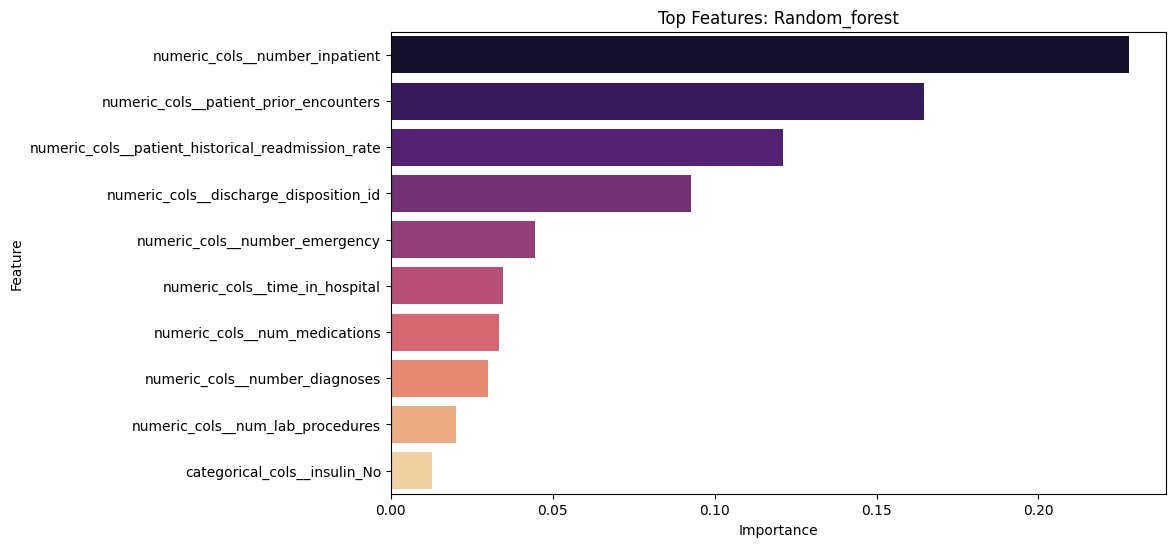

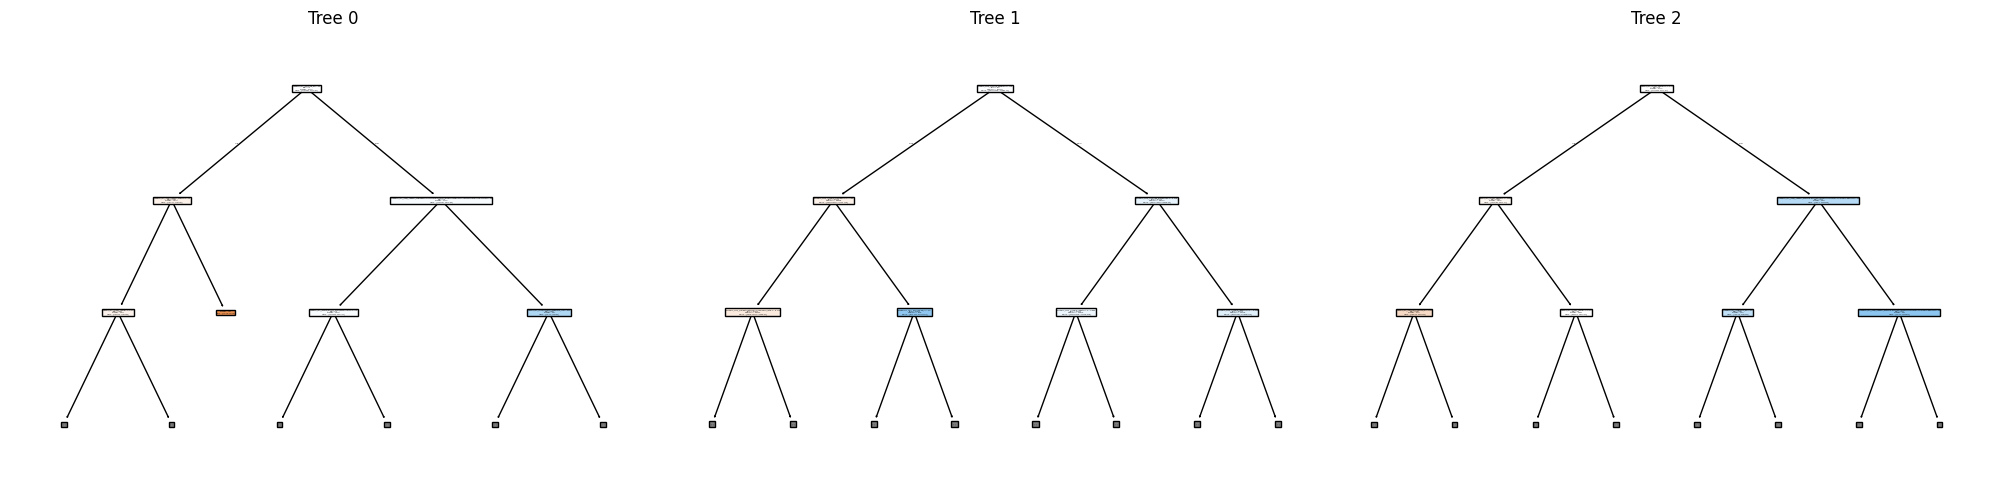

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


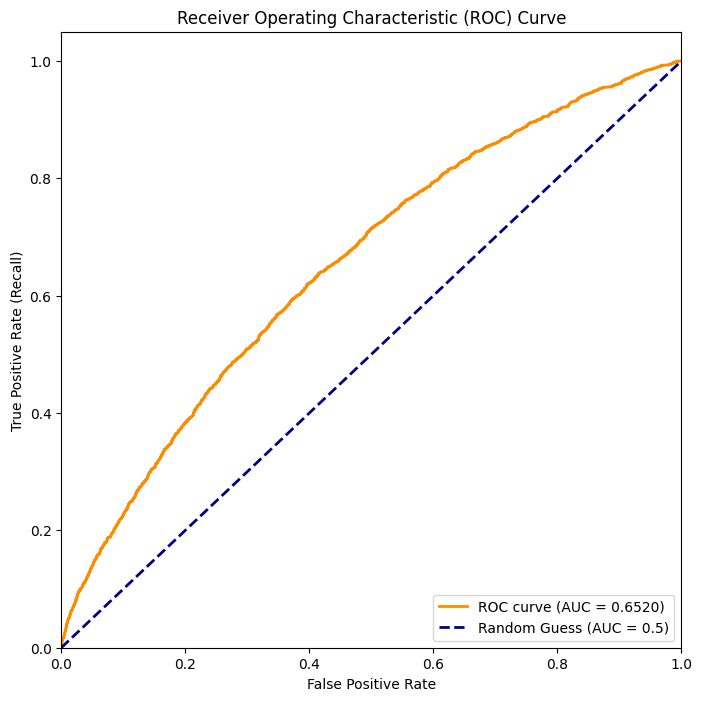

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


,steps,"[('preprocess', ...), ('Random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric_cols', ...), ('categorical_cols', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string re

In [86]:
pipe_rf, metrics_rf = run_random_forest(preprocess,X_train,y_train,X_test,y_test)
pipe_rf

# Gradient Boosting

In [66]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from typing import Union, Dict, Any, Tuple # Keeping type hints here is good practice

# Scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.tree import plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.compose import ColumnTransformer

def plot_feature_importances(pipe: Pipeline, n_top_features: int = 10):
    """
    Extracts and plots feature importances for a Gradient Boosting .
    Note: Gradient Boosting  use 'feature_importances_', not 'coef_'.
    """
    Gb_model = pipe['Gradient_boosting']
    feature_names = pipe['preprocess'].get_feature_names_out()
    
    # Gradient Boosting use Feature Importance (all values are positive and sum to 1)
    importances = Gb_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort and select top N
    plot_data = importance_df.sort_values(by='Importance', ascending=False).head(n_top_features)
    
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')
    plt.title(f'Top {n_top_features} Gradient Boost Feature Importances')
    plt.xlabel('Importance Score (Higher = More Predictive)')
    plt.grid(axis='x', linestyle='--')    
    return fig
def plot_roc_curve(pipe: Pipeline, X_test, y_test):
    """Calculates and plots the ROC curve, returning the Figure object."""
    # Get probability predictions for the positive class (Class 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")    
    return fig
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_metrics(pipe: Pipeline, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.05, 1.01, 0.05)
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        rows.append({
            "Threshold": round(t, 2),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Positive Rate": y_pred.mean()   # % of population flagged diabetic
        })

    return pd.DataFrame(rows)

def run_gradient_boost(preprocess, X_train, y_train, X_test, y_test, Gb_params=None, output_dir="../Outputs/Gradient_boost"):
    
    # Default parameters for a Gradient Boosting
    default_Gb_params = {"random_state": 42, "class_weight":'balanced', "n_estimators":500,"max_depth":8,"min_samples_leaf":50}
    if Gb_params is None:
        Gb_params = default_Gb_params

    # Initialize model and pipeline
    Gb_model = RandomForestClassifier(**Gb_params)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("Gradient_boosting", Gb_model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }

    print("\n--- Evaluation Summary (Random forest) ---")
    print(f"Parameters Used: {Gb_params}") # Fixed from logreg_params
    pprint.pprint(metrics)
    
    os.makedirs(output_dir, exist_ok=True)

    # 1. Feature Importance Plot (Updated from Coefficients)
    imp_fig = plot_feature_importances(pipe)
    imp_fig.savefig(os.path.join(output_dir, "feature_importance.png"), bbox_inches='tight')
    plt.show()
    
    # 2. Tree Visualization (New: Very helpful for Random forest)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    for index in range(0, 3):
        plot_tree(Gb_model.estimators_[index],
                feature_names=pipe['preprocess'].get_feature_names_out(),
                filled=True,
                ax=axes[index],
                max_depth=2)
        axes[index].set_title(f'Tree {index}')

    plt.tight_layout()
    plt.show()

    # 3. ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()

    # Save Metrics
    metrics_filename = os.path.join(output_dir, "metrics.txt")
    with open(metrics_filename, 'w') as f:
        f.write("--- Gradient Boost Evaluation Metrics ---\n\n")
        f.write(pprint.pformat(metrics))
    
    # Threshold Analysis
    threshold_df = threshold_metrics(pipe, X_test, y_test)
    threshold_df.to_csv(os.path.join(output_dir, "threshold_metrics.csv"), index=False)

    return pipe, metrics

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



--- Evaluation Summary (Random forest) ---
Parameters Used: {'random_state': 42, 'class_weight': 'balanced', 'n_estimators': 500, 'max_depth': 8, 'min_samples_leaf': 50}
{'accuracy': 0.6704708976331067,
 'classification_report': {'0': {'f1-score': 0.7887117813623493,
                                 'precision': 0.9230024573683818,
                                 'recall': 0.6885346072658594,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.25171830985915494,
                                 'precision': 0.1661213563355146,
                                 'recall': 0.5192933519293352,
                                 'support': 2151.0},
                           'accuracy': 0.6704708976331067,
                           'macro avg': {'f1-score': 0.5202150456107522,
                                         'precision': 0.5445619068519482,
                                         'recall': 0.6039139795975973,
                       

/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_25168/1313213588.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')


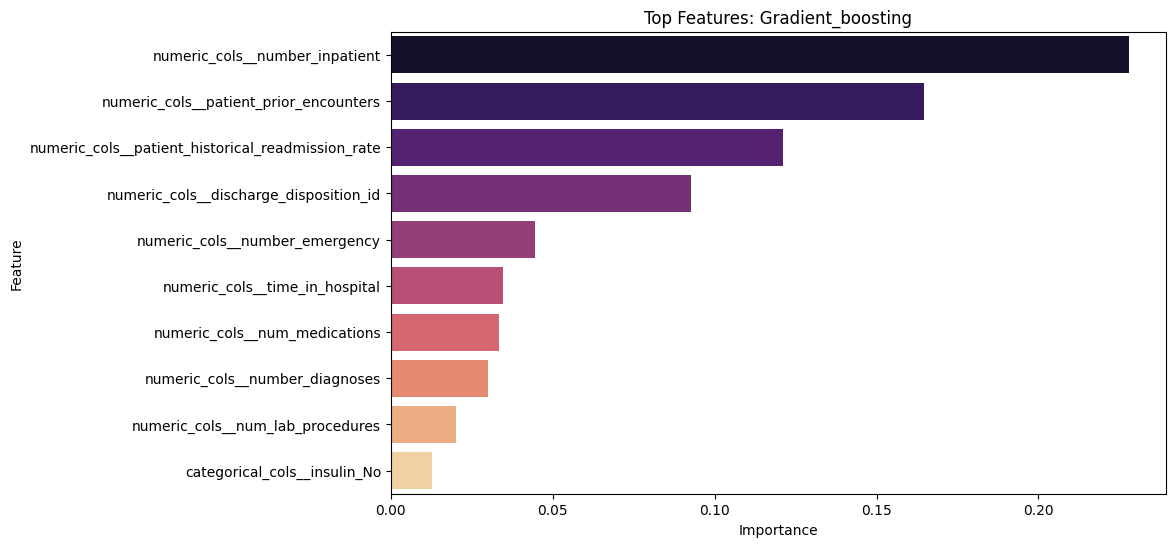

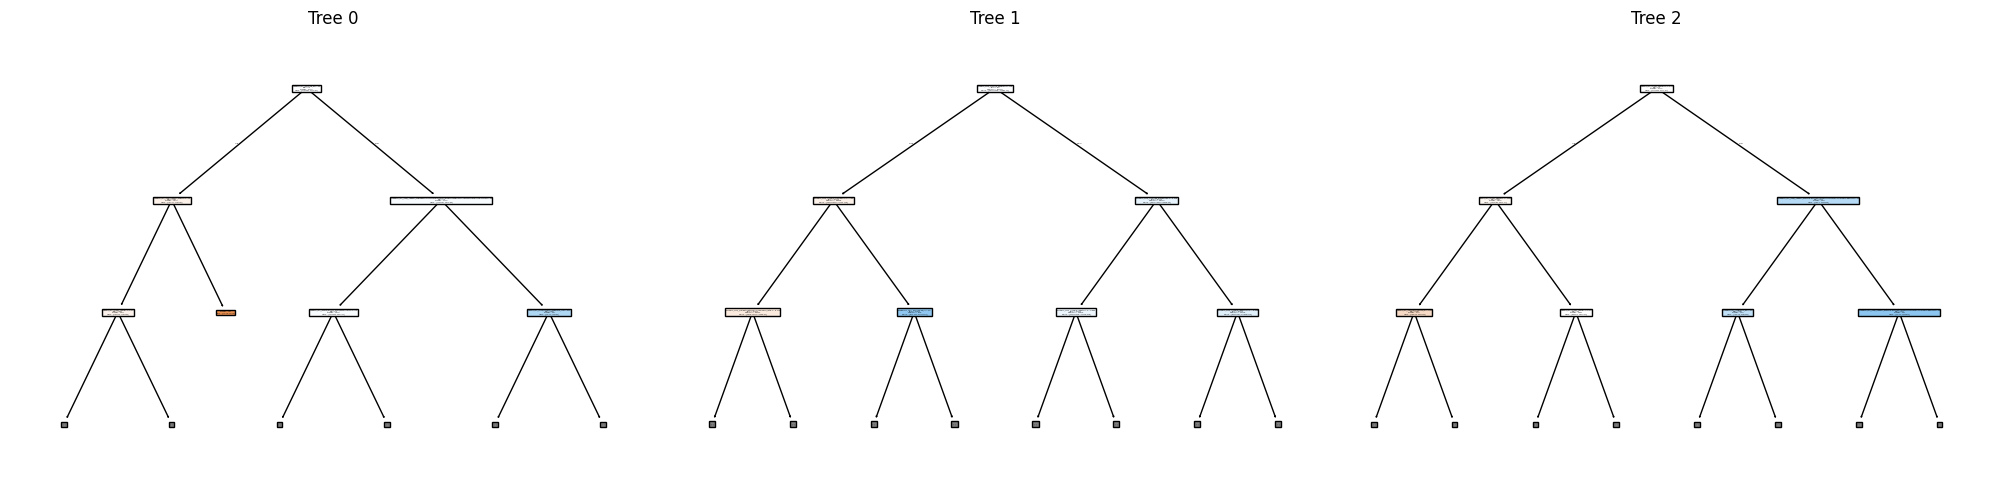

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


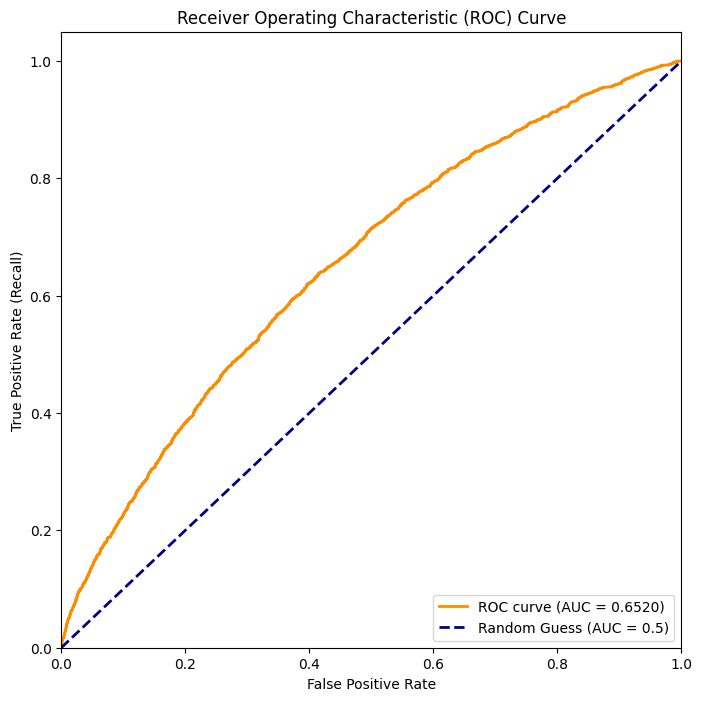

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


,steps,"[('preprocess', ...), ('Gradient_boosting', ...)]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric_cols', ...), ('categorical_cols', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a strin

In [87]:
pipe_gb, metrics_gb = run_gradient_boost(preprocess,X_train,y_train,X_test,y_test)
pipe_gb

# Stacking

In [68]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def plot_stacking_weights(pipe: Pipeline):
    """
    Plots the weights the Meta-Learner gives to each base model.
    """
    stacker = pipe['Stacking']
    # Get names of base models
    model_names = [name for name, _ in stacker.estimators]
    # Get coefficients from the meta-learner (Logistic Regression)
    weights = stacker.final_estimator_.coef_[0]
    
    importance_df = pd.DataFrame({
        'Base Model': model_names,
        'Weight (Coefficient)': weights
    })
    
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Weight (Coefficient)', y='Base Model', data=importance_df, palette='viridis')
    plt.title('Meta-Learner: Which base model is trusted most?')
    return fig

def run_stacking_classifier(preprocess, X_train, y_train, X_test, y_test, output_dir="../Outputs/Stacking"):
    
    # 1. Define Base Models
    base_learners = [
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('lr', LogisticRegression(class_weight='balanced'))
    ]
    
    # 2. Define Meta-Learner (The model that combines the results)
    meta_learner = LogisticRegression()

    # Initialize Stacking Classifier
    stack_model = StackingClassifier(
        estimators=base_learners, 
        final_estimator=meta_learner, 
        cv=5 # Uses cross-validation to train the meta-learner
    )
    
    pipe = Pipeline(steps=[("preprocess", preprocess), ("Stacking", stack_model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }

    print("\n--- Evaluation Summary (Stacking Classifier) ---")
    pprint.pprint(metrics)
    
    os.makedirs(output_dir, exist_ok=True)

    # 3. Meta-Learner Weight Plot
    # Instead of feature importance, we see which model the stacker relies on
    weight_fig = plot_stacking_weights(pipe)
    weight_fig.savefig(os.path.join(output_dir, "meta_learner_weights.png"), bbox_inches='tight')
    plt.show()

    # 4. ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()

    return pipe, metrics

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.htm


--- Evaluation Summary (Stacking Classifier) ---
{'accuracy': 0.8927206867463902,
 'classification_report': {'0': {'f1-score': 0.9432367149758454,
                                 'precision': 0.8943044906900328,
                                 'recall': 0.9978335740473281,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.025247971145175834,
                                 'precision': 0.417910447761194,
                                 'recall': 0.01301720130172013,
                                 'support': 2151.0},
                           'accuracy': 0.8927206867463902,
                           'macro avg': {'f1-score': 0.4842423430605106,
                                         'precision': 0.6561074692256135,
                                         'recall': 0.5054253876745242,
                                         'support': 20153.0},
                           'weighted avg': {'f1-score': 0.8452565736579388,
     

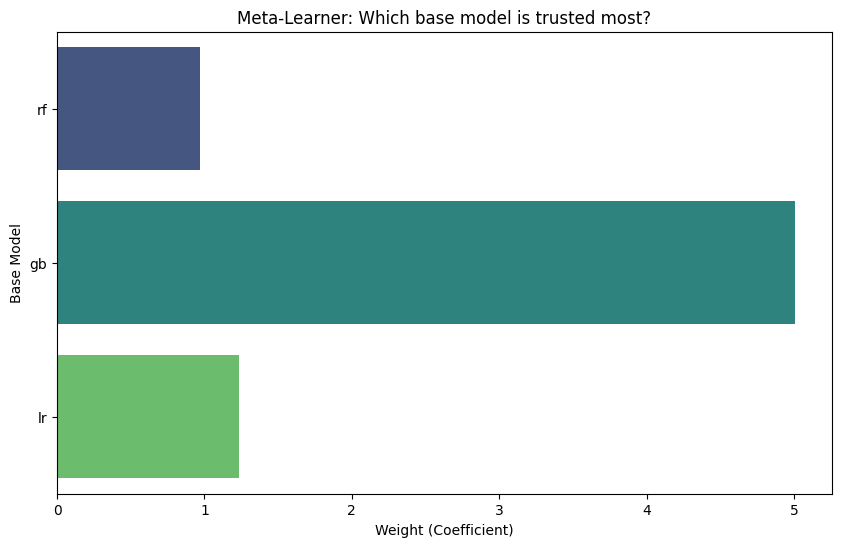

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


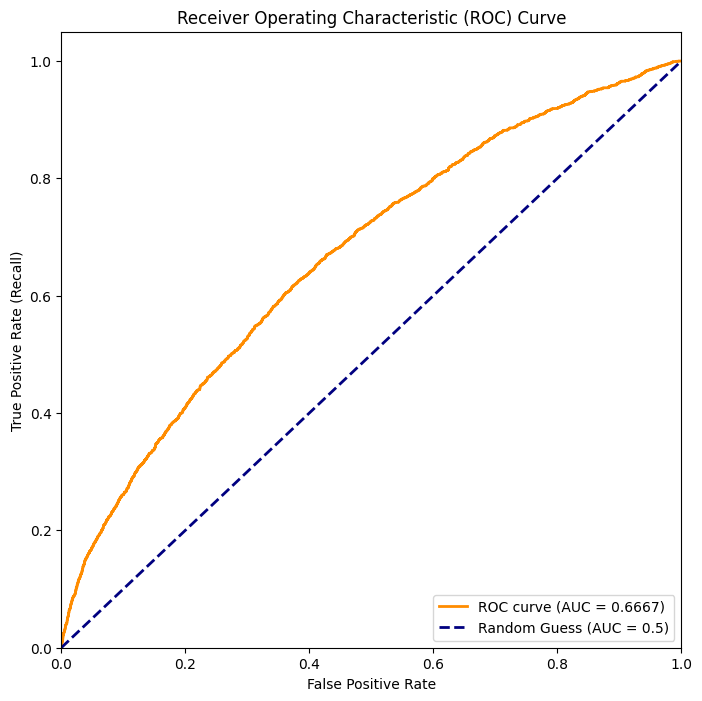

,steps,"[('preprocess', ...), ('Stacking', ...)]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric_cols', ...), ('categorical_cols', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready f

In [89]:
pipe_stack, metrics_stack = run_stacking_classifier(preprocess,X_train,y_train,X_test,y_test)
pipe_stack

# XGboost

In [70]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from typing import Union, Dict, Any, Tuple

# Scikit-learn & XGBoost imports
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.tree import plot_tree

def plot_feature_importances_xgb(pipe: Pipeline, n_top_features: int = 10):
    """
    Extracts and plots feature importances for XGBoost.
    """
    xgb_model = pipe['XGBoost']
    feature_names = pipe['preprocess'].get_feature_names_out()
    
    importances = xgb_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    plot_data = importance_df.sort_values(by='Importance', ascending=False).head(n_top_features)
    
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')
    plt.title(f'Top {n_top_features} XGBoost Feature Importances')
    plt.xlabel('Importance Score')
    plt.grid(axis='x', linestyle='--')    
    return fig

def plot_roc_curve(pipe: Pipeline, X_test, y_test):
    """Calculates and plots the ROC curve."""
    y_proba = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")    
    return fig

def threshold_metrics(pipe: Pipeline, X_test, y_test):
    """Generates a dataframe of metrics at different probability thresholds."""
    y_proba = pipe.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.05, 1.01, 0.05)
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        rows.append({
            "Threshold": round(t, 2),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Positive Rate": y_pred.mean()
        })
    return pd.DataFrame(rows)

def run_xgboost(preprocess, X_train, y_train, X_test, y_test, xgb_params=None, output_dir="../Outputs/XGBoost"):
    """
    Main execution function for XGBoost model training and evaluation.
    """
    # Calculate scale_pos_weight to handle class imbalance
    # Ratio of negative to positive cases
    ratio = (y_train == 0).sum() / (y_train == 1).sum()

    # Default parameters for XGBoost
    default_xgb_params = {
        "n_estimators": 100,
        "max_depth": 5,
        "learning_rate": 0.1,
        "scale_pos_weight": ratio, 
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": 'logloss'
    }
    
    if xgb_params is None:
        xgb_params = default_xgb_params

    # Initialize model and pipeline
    xgb_model = XGBClassifier(**xgb_params)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("XGBoost", xgb_model)])
    
    # Train
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }

    print("\n--- Evaluation Summary (XGBoost) ---")
    pprint.pprint(metrics)
    
    os.makedirs(output_dir, exist_ok=True)

    # 1. Feature Importance Plot
    imp_fig = plot_feature_importances_xgb(pipe)
    imp_fig.savefig(os.path.join(output_dir, "feature_importance.png"), bbox_inches='tight')
    plt.show()
    
    # 2. Tree Visualization
    # Using XGBoost's internal tree plotting (plotting the first tree)
    from xgboost import plot_tree as plot_xgb_tree
    fig, ax = plt.subplots(figsize=(20, 10))
    plot_xgb_tree(pipe['XGBoost'], num_trees=0, ax=ax)
    plt.title("XGBoost Tree Structure (First Tree)")
    plt.savefig(os.path.join(output_dir, "tree_structure.png"))
    plt.show()

    # 3. ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()

    # Save Metrics & Thresholds
    with open(os.path.join(output_dir, "metrics.txt"), 'w') as f:
        f.write(pprint.pformat(metrics))
    
    threshold_df = threshold_metrics(pipe, X_test, y_test)
    threshold_df.to_csv(os.path.join(output_dir, "threshold_metrics.csv"), index=False)

    return pipe, metrics

/Users/iti/miniconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:08:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluation Summary (XGBoost) ---
{'accuracy': 0.6507715972808019,
 'classification_report': {'0': {'f1-score': 0.771136836628512,
                                 'precision': 0.9299607843137255,
                                 'recall': 0.6586490389956672,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.26334519572953735,
                                 'precision': 0.16993110900986086,
                                 'recall': 0.5848442584844259,
                                 'support': 2151.0},
                           'accuracy': 0.6507715972808019,
                           'macro avg': {'f1-score': 0.5172410161790246,
                                         'precision': 0.5499459466617932,
                                         'recall': 0.6217466487400465,
                                         'support': 20153.0},
                           'weighted avg': {'f1-score': 0.7169384632065057,
                  

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_25168/967558880.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=plot_data, palette='magma')


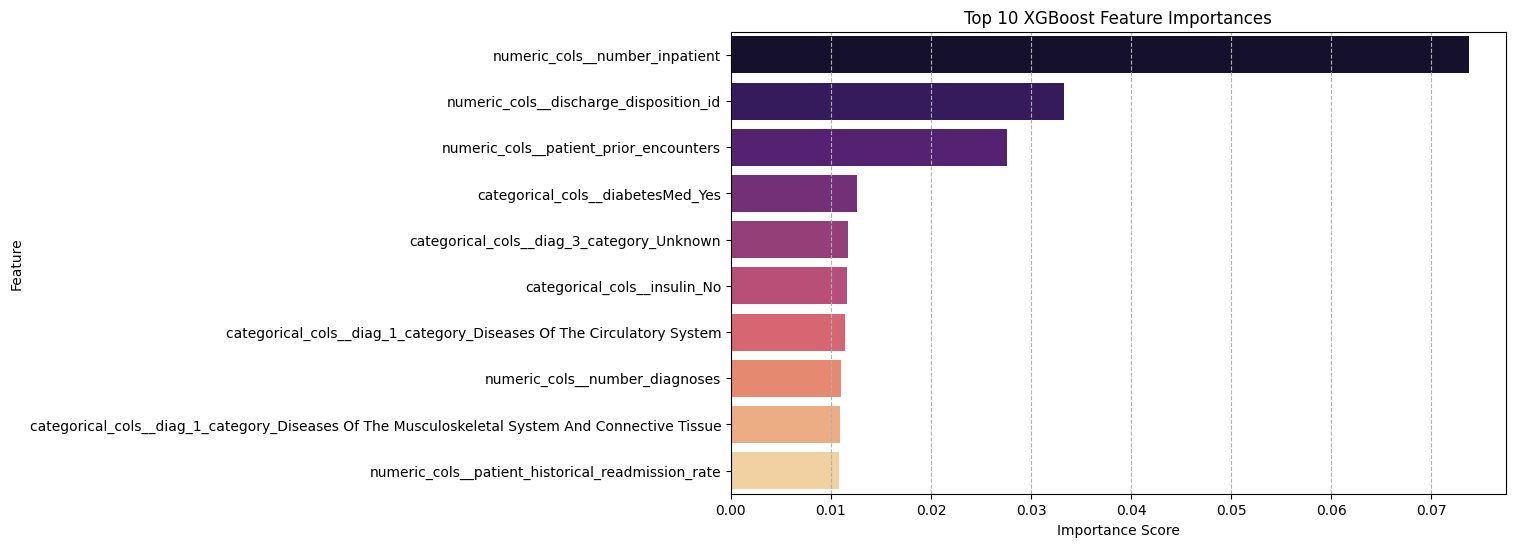

/Users/iti/miniconda3/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


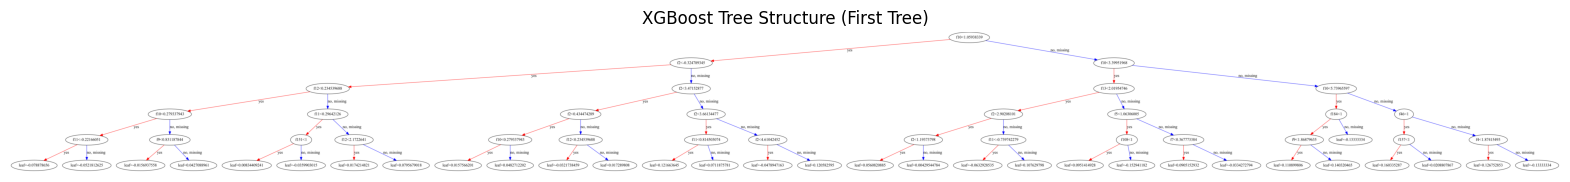

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


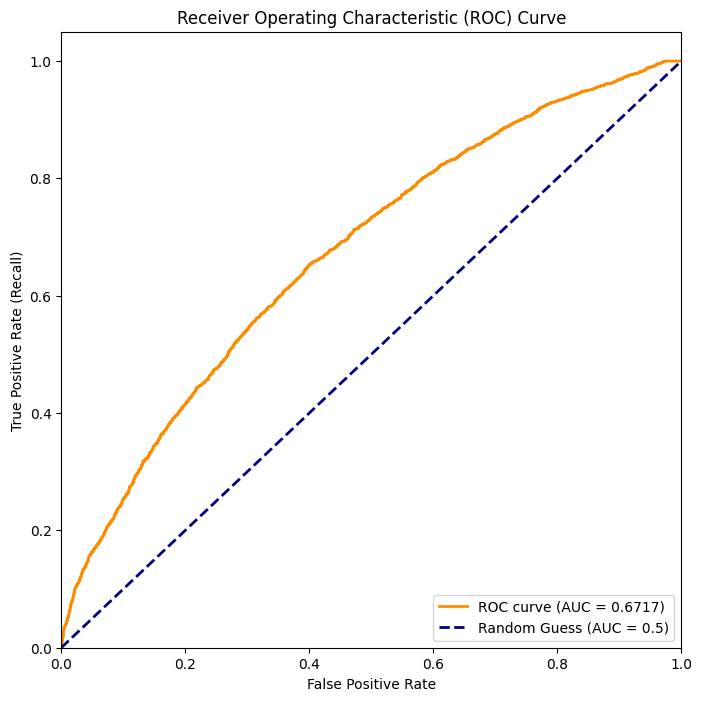

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


,steps,"[('preprocess', ...), ('XGBoost', ...)]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric_cols', ...), ('categorical_cols', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready fo

In [88]:
pipe_xgb, metrics_xgb = run_xgboost(preprocess,X_train,y_train,X_test,y_test)
pipe_xgb

# Compare all models metrics

<Figure size 1200x600 with 0 Axes>

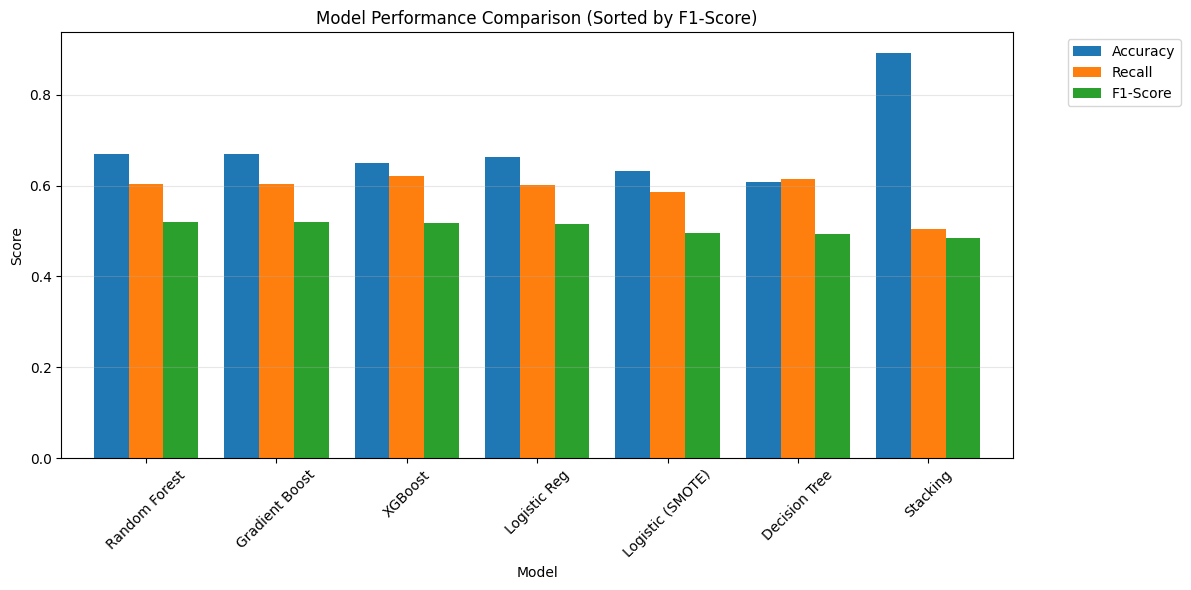


--- Verified Metrics Table ---


,Accuracy,Recall,F1-Score
Model,,,
Random Forest,0.670471,0.603914,0.520215
Gradient Boost,0.670471,0.603914,0.520215
XGBoost,0.650772,0.621747,0.517241
Logistic Reg,0.662829,0.600660,0.515468
Logistic (SMOTE),0.631320,0.585070,0.495416
Decision Tree,0.607651,0.615417,0.493849
Stacking,0.892721,0.505425,0.484242


/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3, 11, 20, 26, 29] during transform. These unknown categories

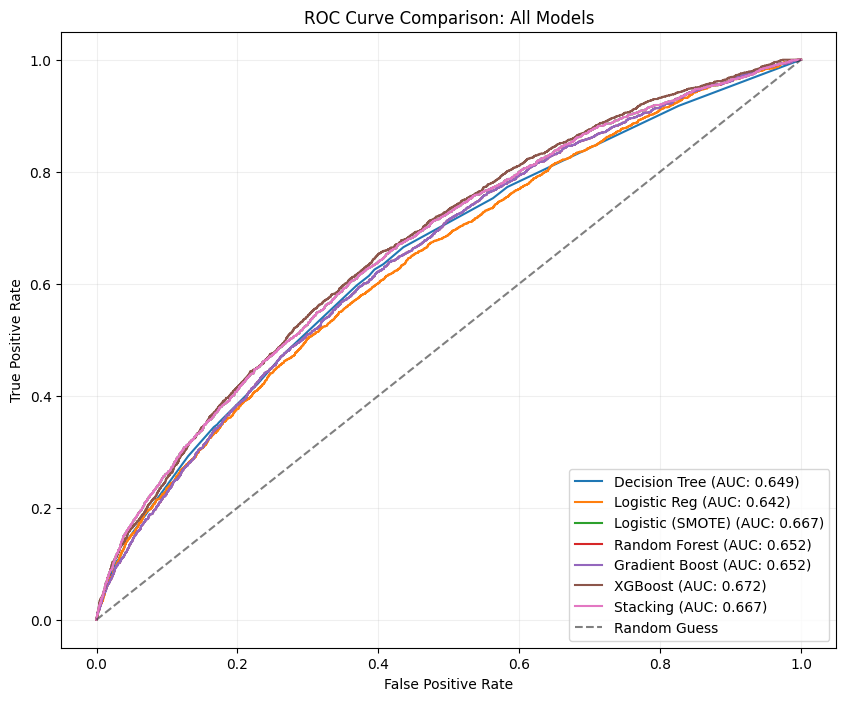


Files saved successfully in: /Users/iti/Upskilling/Data_Science_Projects/Diabetes_classification_project/Notebooks/model_comparision


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Setup Folder
output_folder = "model_comparision"
os.makedirs(output_folder, exist_ok=True)

# 2. Map existing variables (Ensure names match your notebook variables)
results_map = {
    "Decision Tree": metrics_dt if 'metrics_dt' in locals() else None,
    "Logistic Reg": metrics_lr if 'metrics_lr' in locals() else None,
    "Logistic (SMOTE)": metrics if 'metrics' in locals() else None,
    "Random Forest": metrics_rf if 'metrics_rf' in locals() else None,
    "Gradient Boost": metrics_gb if 'metrics_gb' in locals() else None,
    "XGBoost": metrics_xgb if 'metrics_xgb' in locals() else None,
    "Stacking": metrics_stack if 'metrics_stack' in locals() else None
}

pipes_map = {
    "Decision Tree": pipe_dt if 'pipe_dt' in locals() else None,
    "Logistic Reg": pipe_lr if 'pipe_lr' in locals() else None,
    "Logistic (SMOTE)": pipe if 'pipe' in locals() else None,
    "Random Forest": pipe_rf if 'pipe_rf' in locals() else None,
    "Gradient Boost": pipe_gb if 'pipe_gb' in locals() else None,
    "XGBoost": pipe_xgb if 'pipe_xgb' in locals() else None,
    "Stacking": pipe_stack if 'pipe_stack' in locals() else None
}

# --- 3. ROBUST METRIC EXTRACTION ---
final_metrics = []

for name, m in results_map.items():
    if m is not None:
        # Pull basic metrics
        acc = m.get("accuracy") or 0
        f1 = m.get("f1_score_macro") or 0
        
        # Pull Recall (with fallback for the Stacking nested structure)
        rec = m.get("recall_macro") 
        if rec is None:
            try:
                # This specifically targets the structure you shared for Stacking
                rec = m['classification_report']['macro avg']['recall']
            except (KeyError, TypeError):
                rec = 0
        
        final_metrics.append({
            "Model": name,
            "Accuracy": acc,
            "Recall": rec,
            "F1-Score": f1
        })

# --- 4. GENERATE & SAVE BAR PLOT ---
if final_metrics:
    df_compare = pd.DataFrame(final_metrics).set_index("Model")
    df_compare.sort_values("F1-Score", ascending=False, inplace=True)
    
    plt.figure(figsize=(12, 6))
    ax = df_compare.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title("Model Performance Comparison (Sorted by F1-Score)")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(os.path.join(output_folder, "performance_comparison_bar.png"), bbox_inches='tight')
    plt.show()
    
    print("\n--- Metrics Table ---")
    display(df_compare)

# --- 5. GENERATE & SAVE ROC CURVE COMPARISON ---
plt.figure(figsize=(10, 8))
has_roc = False

for name, pipe in pipes_map.items():
    if pipe is not None:
        try:
            # Get probabilities for class 1
            y_proba = pipe.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_val = roc_auc_score(y_test, y_proba)
            
            plt.plot(fpr, tpr, label=f"{name} (AUC: {auc_val:.3f})")
            has_roc = True
        except Exception as e:
            print(f"Skipping ROC for {name}: {e}")

if has_roc:
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison: All Models")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.2)
    
    plt.savefig(os.path.join(output_folder, "roc_comparison_curve.png"), bbox_inches='tight')
    plt.show()
    
print(f"\nFiles saved successfully in: {os.path.abspath(output_folder)}")

# Kurtosis

In [35]:
##Use kurtosis to check the data distribution of numerical columns
import pandas as pd
from scipy.stats import kurtosis

kurtosis_df = pd.DataFrame({
    "feature": numeric_cols,
    "kurtosis": [
        kurtosis(X_train[col].dropna(), fisher=True)
        for col in numeric_cols
    ]
}).sort_values("kurtosis", ascending=False)

kurtosis_df


,feature,kurtosis
9,number_emergency,1276.962180
8,number_outpatient,145.983075
12,patient_prior_encounters,68.459975
0,weight,26.374356
10,number_inpatient,22.057557
13,patient_historical_readmission_rate,8.469911
2,discharge_disposition_id,6.002153
7,num_medications,3.557642
1,admission_type_id,1.910007
3,admission_source_id,1.729944


| Kurtosis (Fisher) | Interpretation | Recommended Transform         |
| ----------------- | -------------- | ----------------------------- |
| > +1              | Heavy-tailed   | `log1p` or `PowerTransformer` |
| −1 to +1          | Near-normal    | `StandardScaler`              |
| < −1              | Light-tailed   | Usually no transform          |


In [37]:
high_kurtosis_cols = kurtosis_df.loc[
    kurtosis_df["kurtosis"] > 1, "feature"
].tolist()

normal_kurtosis_cols = kurtosis_df.loc[
    kurtosis_df["kurtosis"].between(-1, 1), "feature"
].tolist()


In [38]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer(transformers=[
    ("num_normal", StandardScaler(), normal_kurtosis_cols),
    ("num_heavy", PowerTransformer(method="yeo-johnson"), high_kurtosis_cols),
    ("categorical_cols", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)])


In [39]:
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        class_weight="balanced",
        random_state=42
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))

accuracy 0.6380191534759093
precision 0.5413488141113721
F1 Score 0.5041990724555754
Recall 0.6015093317540884
classification report               precision    recall  f1-score   support

           0       0.92      0.65      0.76     18002
           1       0.16      0.56      0.25      2151

    accuracy                           0.64     20153
   macro avg       0.54      0.60      0.50     20153
weighted avg       0.84      0.64      0.71     20153

confusion_matrix [[11664  6338]
 [  957  1194]]


/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
from sklearn.tree import DecisionTreeClassifier
pipe=Pipeline(steps=[("preprocess", preprocess),
                     ("Decision_tree", DecisionTreeClassifier(class_weight="balanced",max_depth=5,random_state=42, min_samples_leaf=100))]
)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
# The baseline Decision Tree model underperforms Logistic Regression, particularly for the clinically important <30 readmission class, 
# indicating that a single tree is too unstable to capture the complex patterns required for early readmission prediction.
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))

accuracy 0.6076514662829355
precision 0.5451996414304182
F1 Score 0.4938485613619674
Recall 0.6154171954962802
classification report               precision    recall  f1-score   support

           0       0.93      0.61      0.73     18002
           1       0.16      0.63      0.25      2151

    accuracy                           0.61     20153
   macro avg       0.55      0.62      0.49     20153
weighted avg       0.85      0.61      0.68     20153

confusion_matrix [[10901  7101]
 [  806  1345]]


## create a bar plot and compare all the models
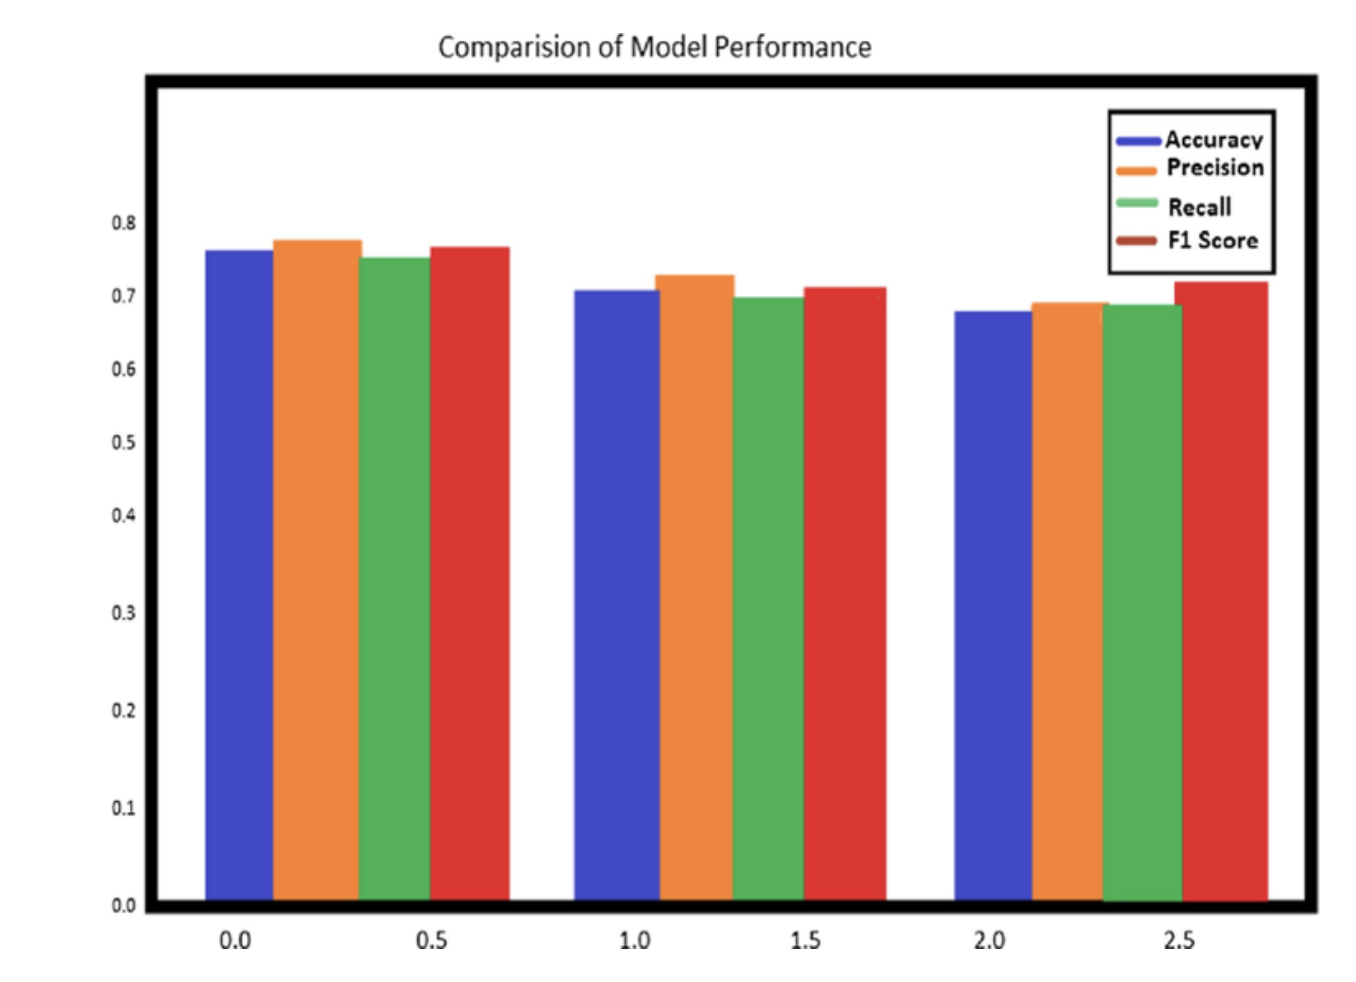

3. Statistics & Experimental Thinking

This is where your academic background is a major advantage.

In demand:

Probability distributions

Hypothesis testing

Confidence intervals

Regression assumptions

A/B testing logic

Bias & variance trade-offs

Interview framing:

“How do you know your result is meaningful?